### EDA imagenes MRI

In [1]:
# Importacion librerias necesarias

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

In [3]:
# Paths
train_path = "Data/Training"
test_path = "Data/Testing"

# Función para obtener clases y conteo de imágenes
def get_image_counts(base_path):
    classes = os.listdir(base_path)
    counts = {}
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        if os.path.isdir(class_path):
            counts[cls] = len(os.listdir(class_path))
    return counts

train_counts = get_image_counts(train_path)
test_counts = get_image_counts(test_path)

# Conteo total
total_counts = Counter(train_counts) + Counter(test_counts)

print("Conteo TRAIN:", train_counts)
print("Conteo TEST:", test_counts)
print("Conteo TOTAL:", total_counts)

# DataFrame de proporciones
df_counts = pd.DataFrame({
    "train": train_counts,
    "test": test_counts,
    "total": total_counts
}).fillna(0).astype(int)

# Proporciones
df_counts["train_prop"] = df_counts["train"] / df_counts["train"].sum()
df_counts["test_prop"] = df_counts["test"] / df_counts["test"].sum()
df_counts["total_prop"] = df_counts["total"] / df_counts["total"].sum()

print(df_counts)


Conteo TRAIN: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Conteo TEST: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}
Conteo TOTAL: Counter({'notumor': 2000, 'pituitary': 1757, 'meningioma': 1645, 'glioma': 1621})
            train  test  total  train_prop  test_prop  total_prop
glioma       1321   300   1621    0.231268   0.228833    0.230813
meningioma   1339   306   1645    0.234419   0.233410    0.234230
notumor      1595   405   2000    0.279237   0.308924    0.284779
pituitary    1457   300   1757    0.255077   0.228833    0.250178


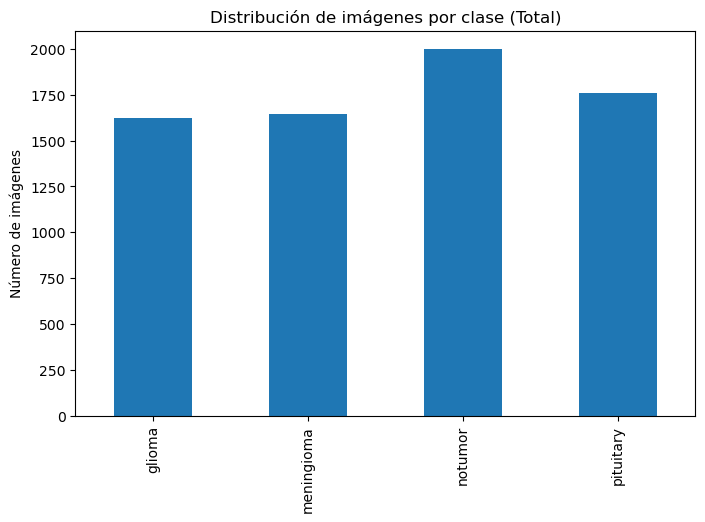

100%|██████████| 50/50 [00:00<00:00, 145.64it/s]


   brightness  saturation   contrast  homogeneity    energy   class  \
0   31.387234         0.0  43.933456     0.642711  0.284551  glioma   
1   37.844910         0.0  46.111989     0.617918  0.258267  glioma   
2   36.035866         0.0  48.040140     0.615435  0.250698  glioma   
3   24.906197         0.0  33.926920     0.639808  0.259433  glioma   
4   32.082684         0.0  37.867944     0.574563  0.231192  glioma   

           split  
0  Data/Training  
1  Data/Training  
2  Data/Training  
3  Data/Training  
4  Data/Training  


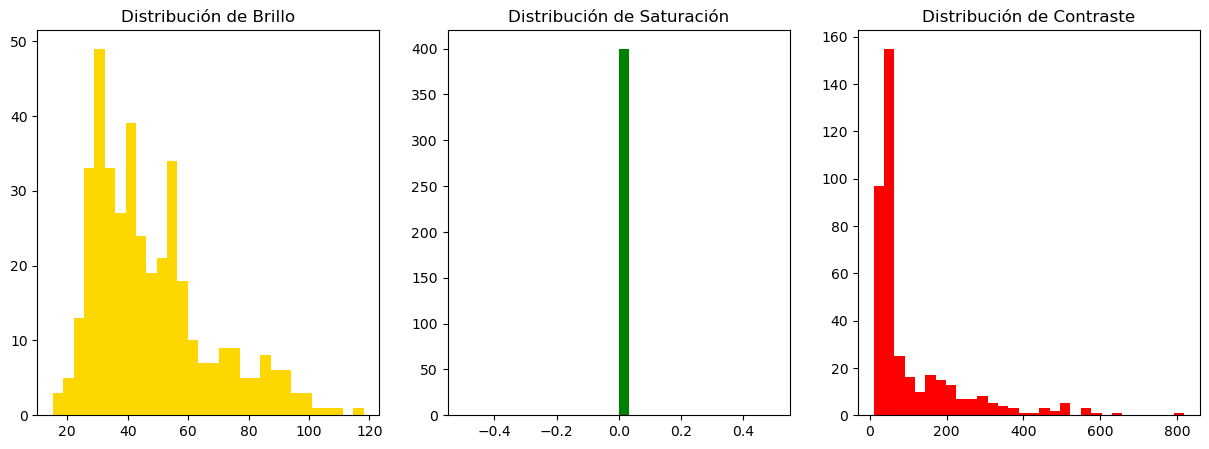

In [4]:

# Gráfico de distribución
df_counts["total"].plot(kind="bar", figsize=(8,5), title="Distribución de imágenes por clase (Total)")
plt.ylabel("Número de imágenes")
plt.show()

# ------------------------
# Análisis de características de imágenes
# ------------------------

def analyze_image_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convertir a HSV para brillo y saturación
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # Histogramas de color RGB
    color_hist = [cv2.calcHist([img], [i], None, [256], [0, 256]) for i in range(3)]
    
    # Promedio de brillo y saturación
    brightness = np.mean(v)
    saturation = np.mean(s)

    # Textura con GLCM
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]

    return {
        "brightness": brightness,
        "saturation": saturation,
        "contrast": contrast,
        "homogeneity": homogeneity,
        "energy": energy
    }

# Extraer características de una muestra de imágenes
features = []
base_paths = [train_path, test_path]

for base in base_paths:
    for cls in os.listdir(base):
        class_path = os.path.join(base, cls)
        if os.path.isdir(class_path):
            for img_name in tqdm(os.listdir(class_path)[:50]):  # limitar a 50 por clase para acelerar
                img_path = os.path.join(class_path, img_name)
                feats = analyze_image_features(img_path)
                feats["class"] = cls
                feats["split"] = base
                features.append(feats)

df_features = pd.DataFrame(features)
print(df_features.head())

# Histogramas globales
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(df_features["brightness"], bins=30, color="gold")
axs[0].set_title("Distribución de Brillo")
axs[1].hist(df_features["saturation"], bins=30, color="green")
axs[1].set_title("Distribución de Saturación")
axs[2].hist(df_features["contrast"], bins=30, color="red")
axs[2].set_title("Distribución de Contraste")
plt.show()


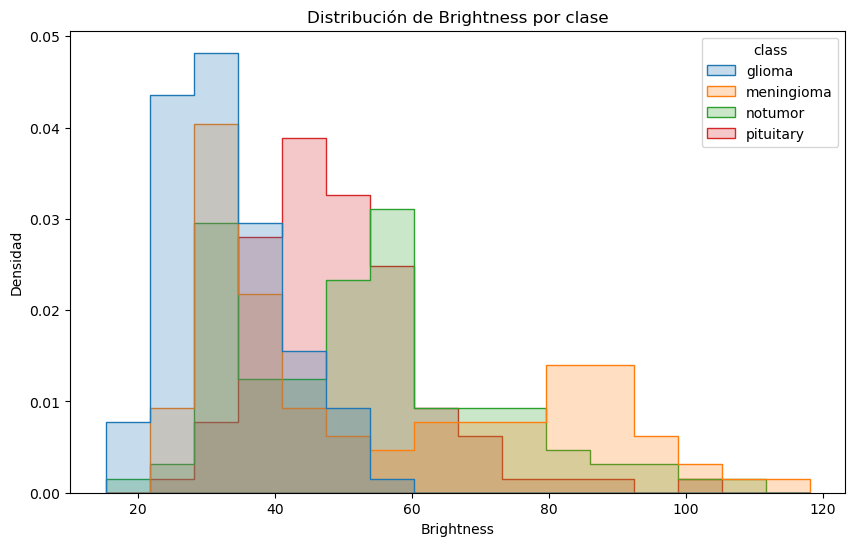

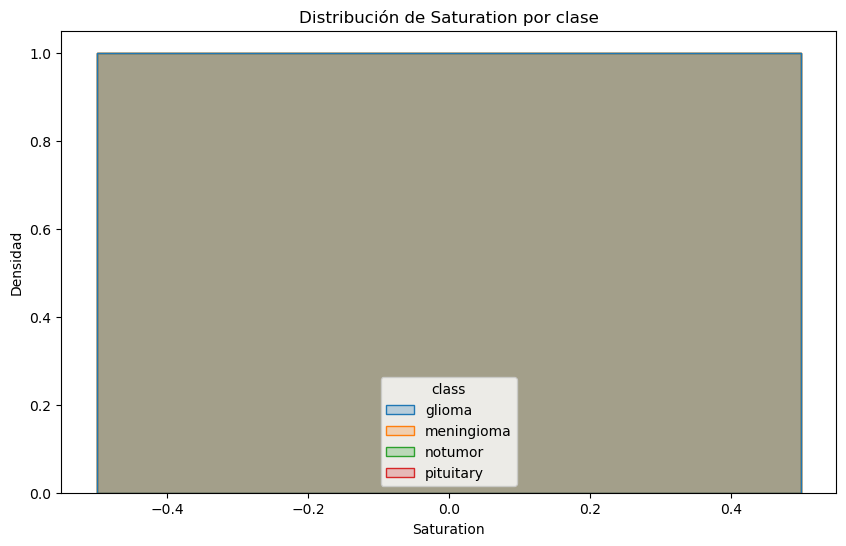

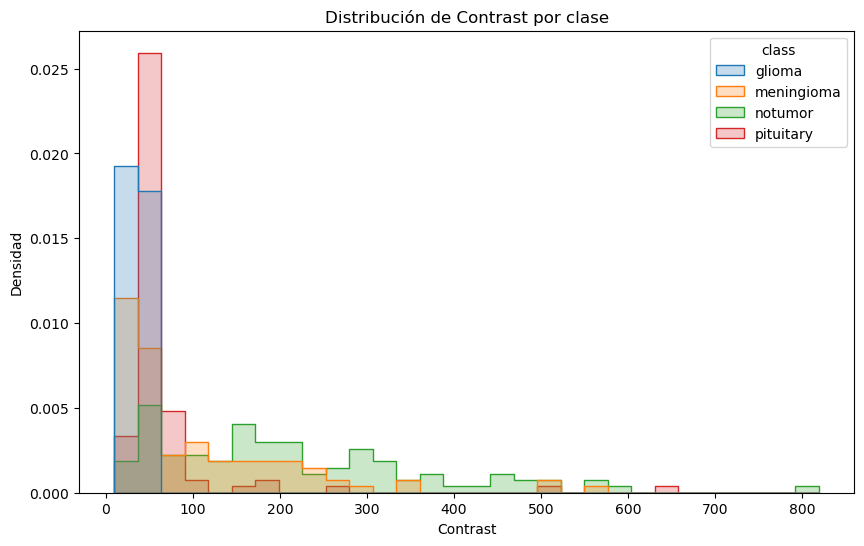

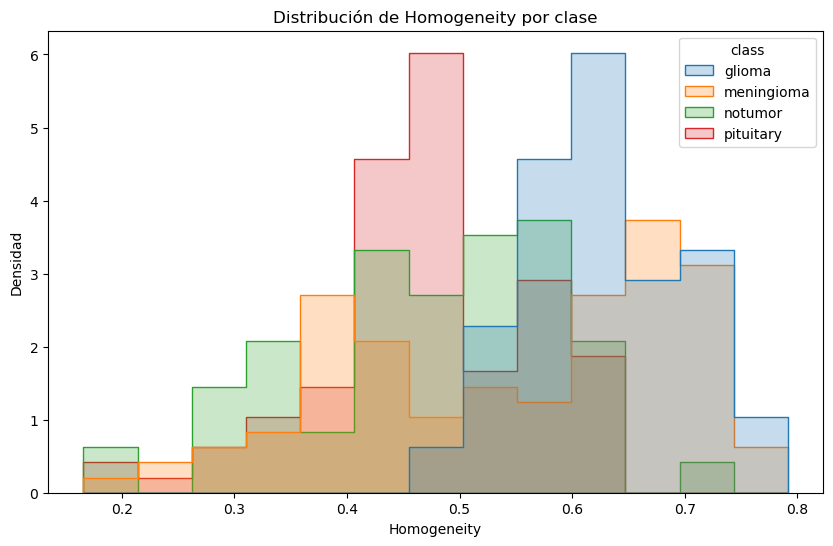

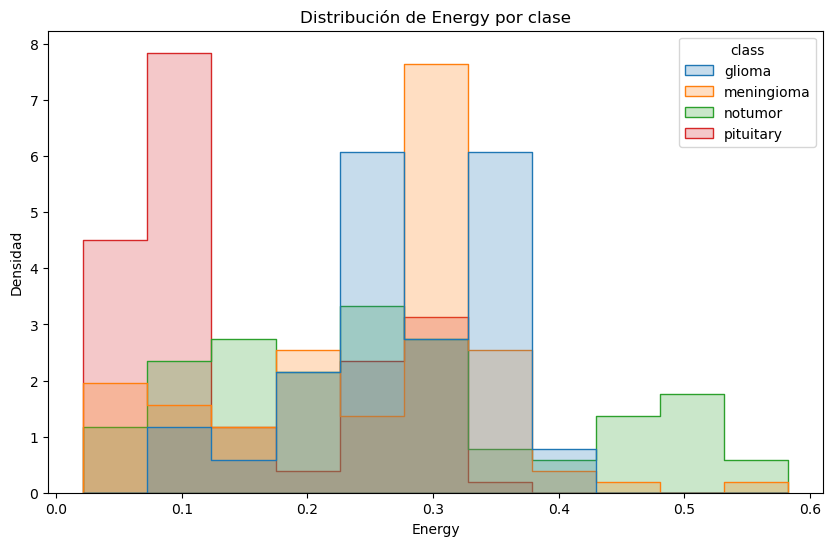

In [ ]:
features_to_plot = ["brightness", "contrast","homogeneity", "energy"]

for feat in features_to_plot:
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df_features, x=feat, hue="class", element="step", stat="density", common_norm=False)

    # Añadir nombres de clase en la gráfica
    handles, labels = ax.get_legend_handles_labels()
    for h, l in zip(handles, labels[1:]):  # [1:] para evitar "None"
        ax.text(0.95, 0.95 - 0.05*labels.index(l), l,
                transform=ax.transAxes, fontsize=10, color=h.get_edgecolor()[0],
                ha="right", va="top")

    ax.set_title(f"Distribución de {feat.capitalize()} por clase")
    ax.set_xlabel(feat.capitalize())
    ax.set_ylabel("Densidad")
    plt.show()

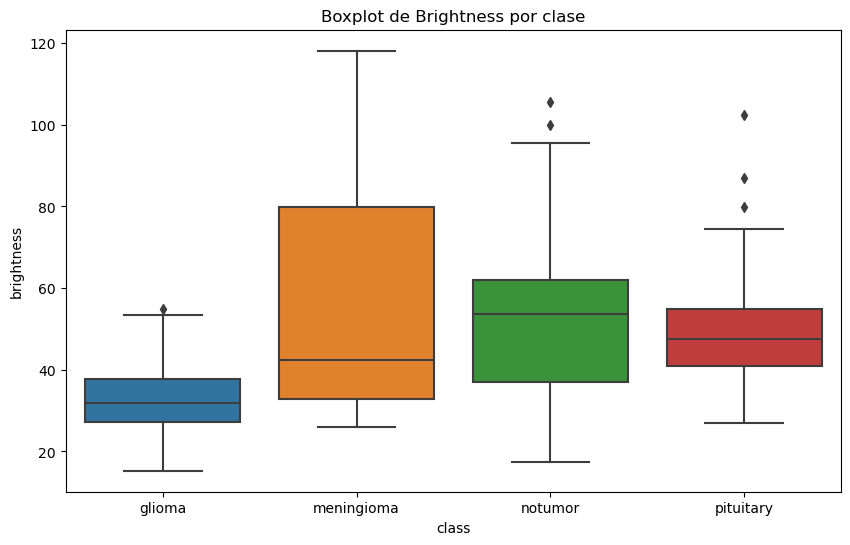

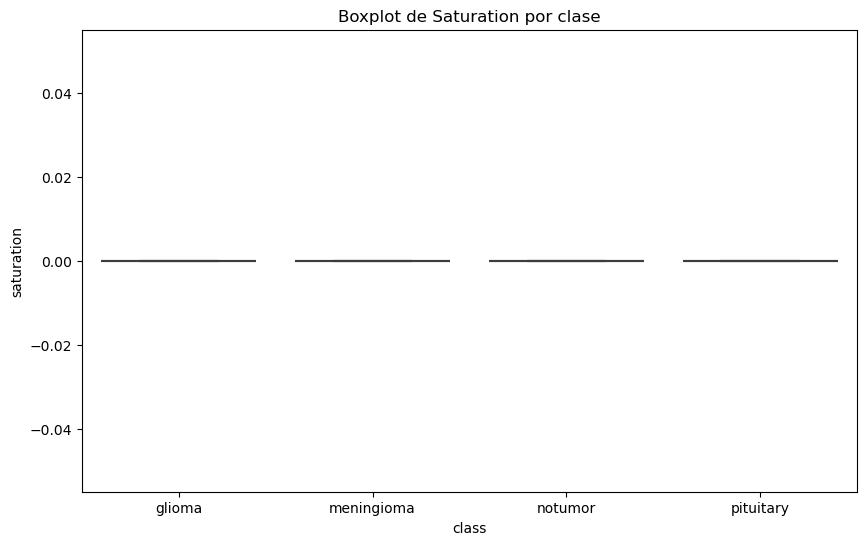

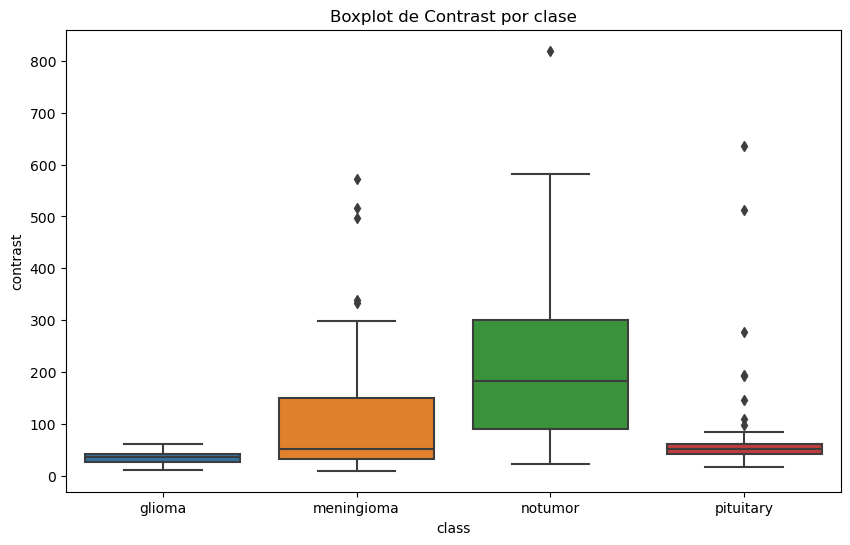

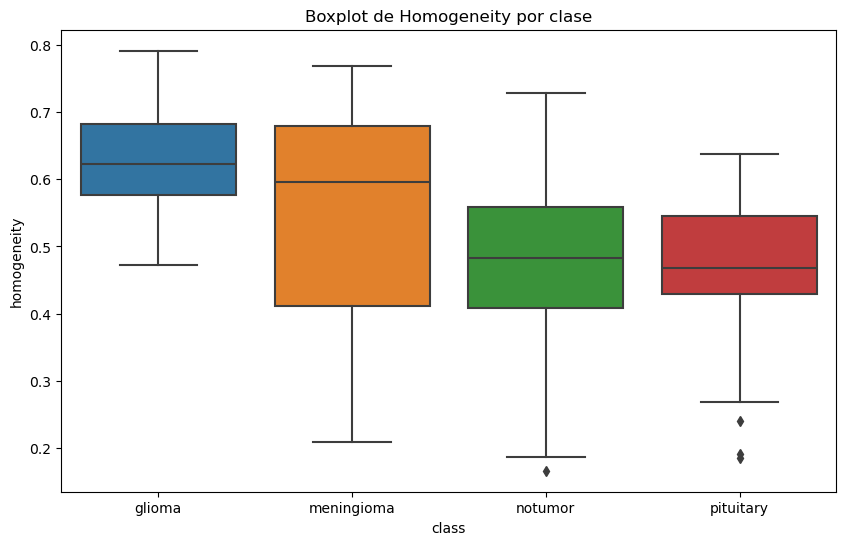

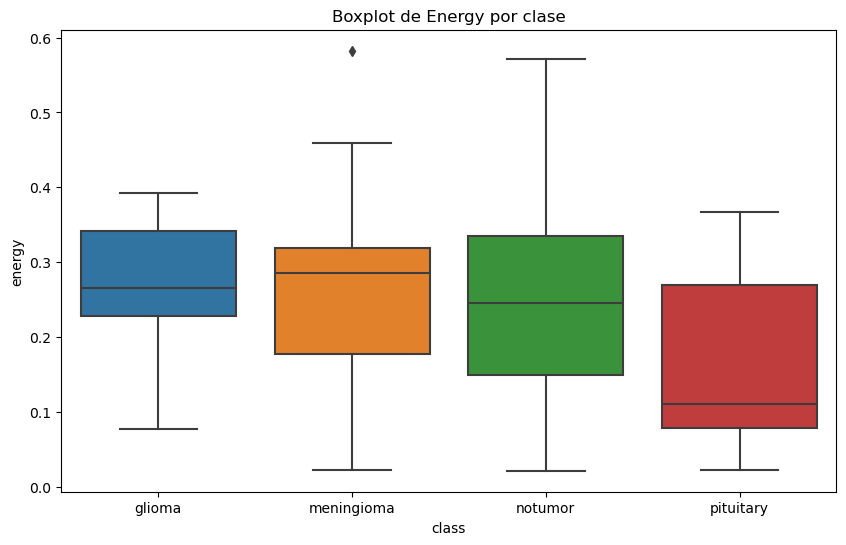

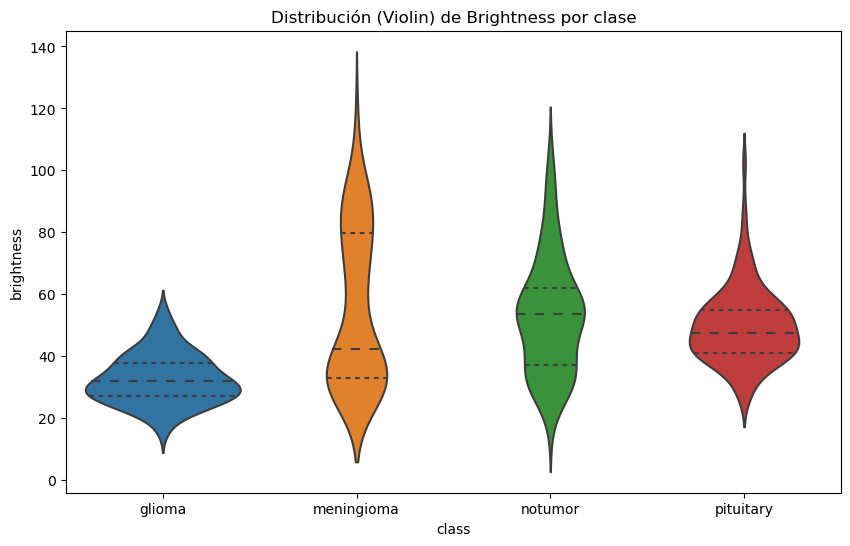

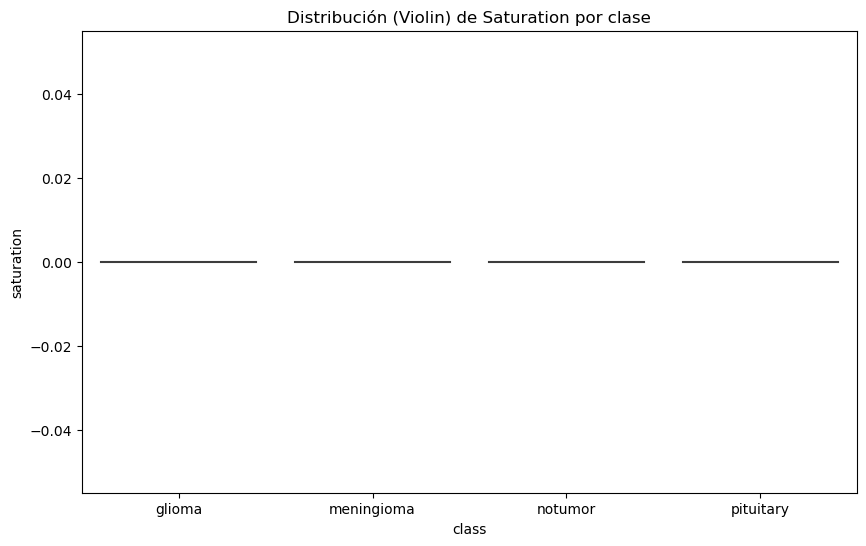

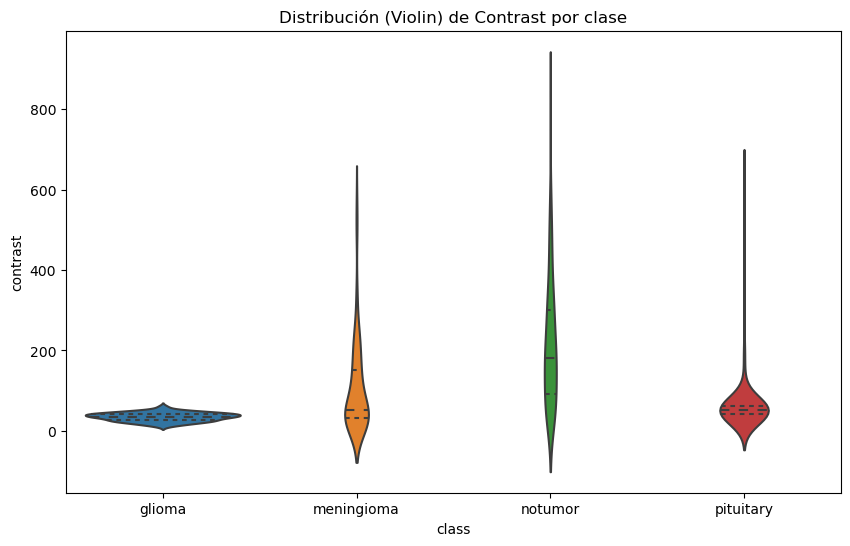

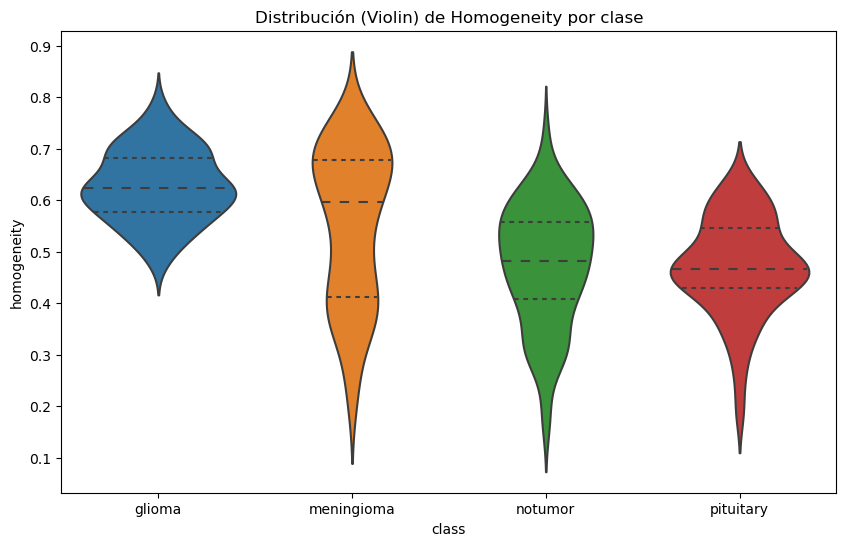

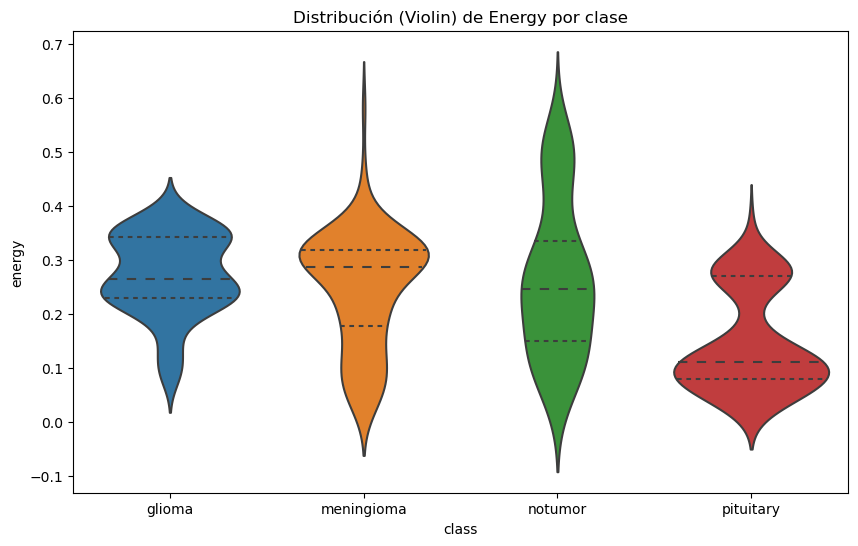

In [11]:
for feat in features_to_plot:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=df_features, x="class", y=feat)
    ax.set_title(f"Boxplot de {feat.capitalize()} por clase")
    plt.show()

for feat in features_to_plot:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(data=df_features, x="class", y=feat, inner="quartile")
    ax.set_title(f"Distribución (Violin) de {feat.capitalize()} por clase")
    plt.show()


tumor      300
notumor    100
Name: class_grouped, dtype: int64
Estadísticas agrupadas:
              brightness                                      contrast  \
                    mean        std        min         max        mean   
class_grouped                                                            
notumor        52.947394  18.552319  17.430408  105.709308  215.040246   
tumor          45.817555  19.382510  15.267933  118.154223   69.598773   

                                                 homogeneity            \
                      std        min         max        mean       std   
class_grouped                                                            
notumor        155.029071  21.786657  819.442539    0.474204  0.116772   
tumor           84.163781   9.684993  635.430127    0.548865  0.127505   

                                    energy                                
                   min       max      mean       std       min       max  
class_grouped       

C:\Users\moren\AppData\Local\Temp\ipykernel_22428\438300887.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clase")


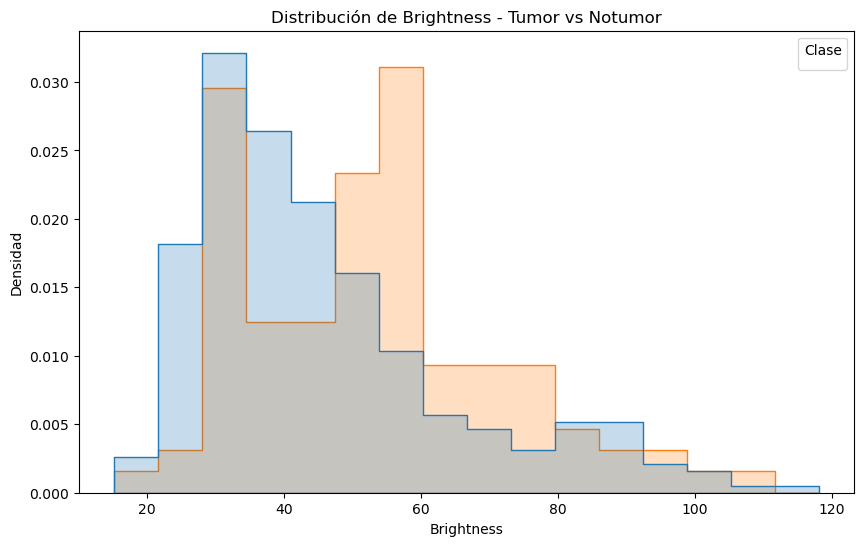

C:\Users\moren\AppData\Local\Temp\ipykernel_22428\438300887.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clase")


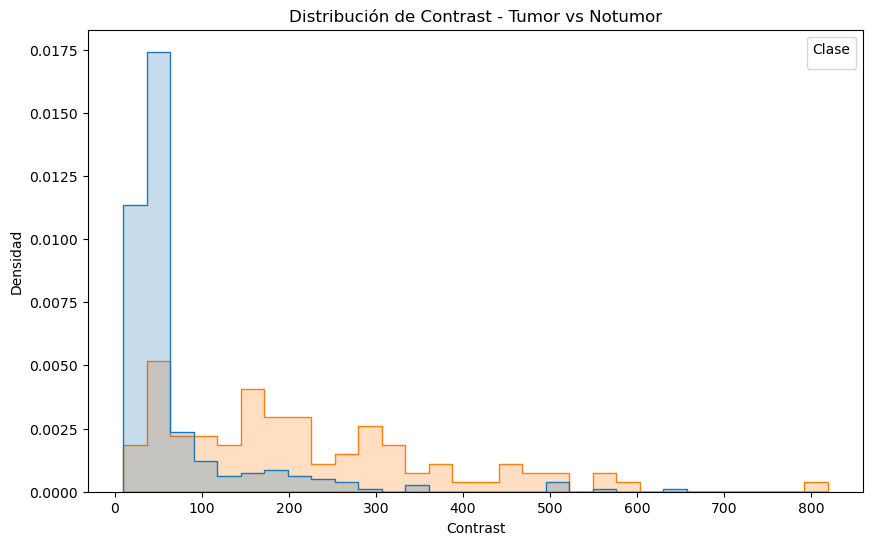

C:\Users\moren\AppData\Local\Temp\ipykernel_22428\438300887.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clase")


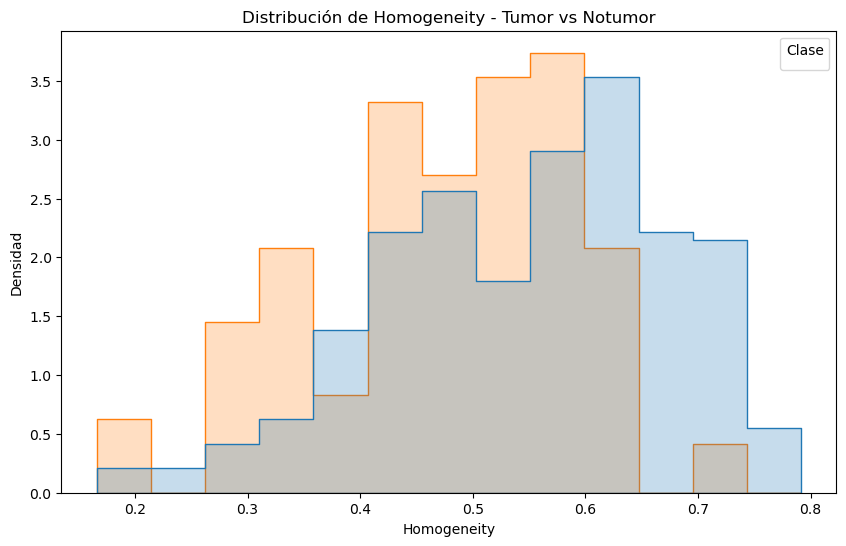

C:\Users\moren\AppData\Local\Temp\ipykernel_22428\438300887.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clase")


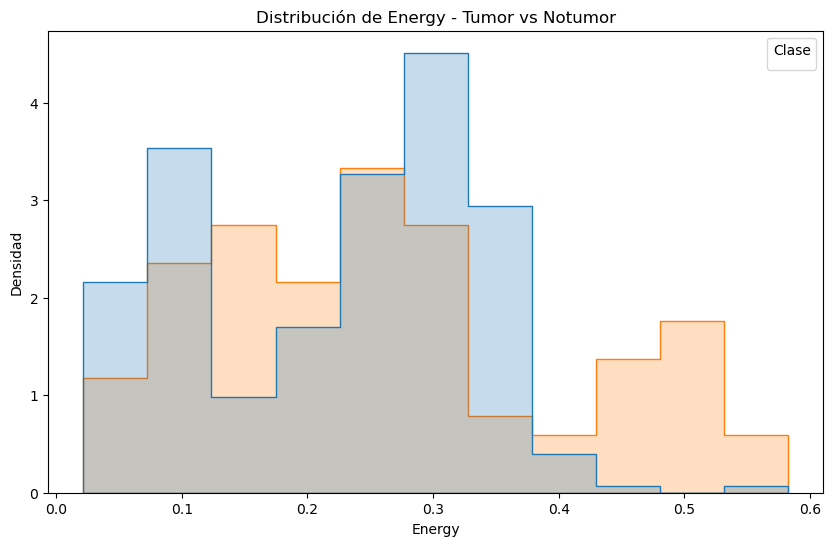

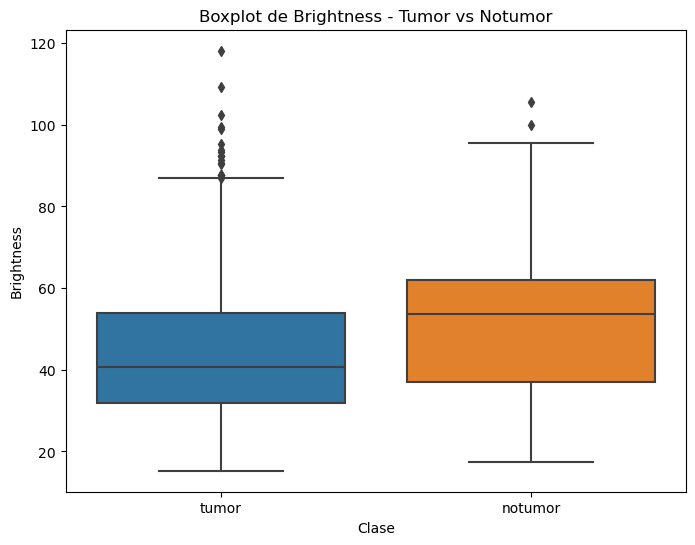

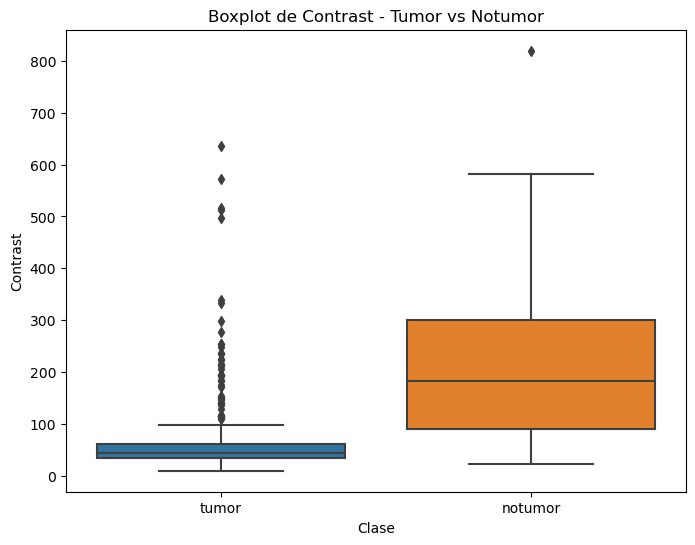

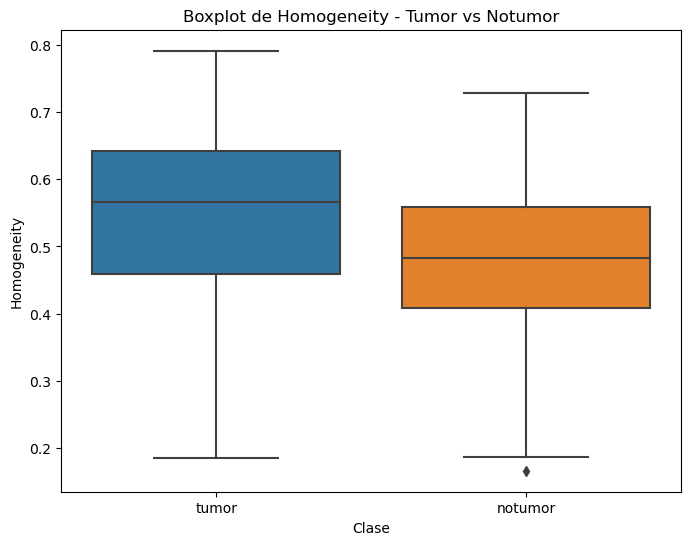

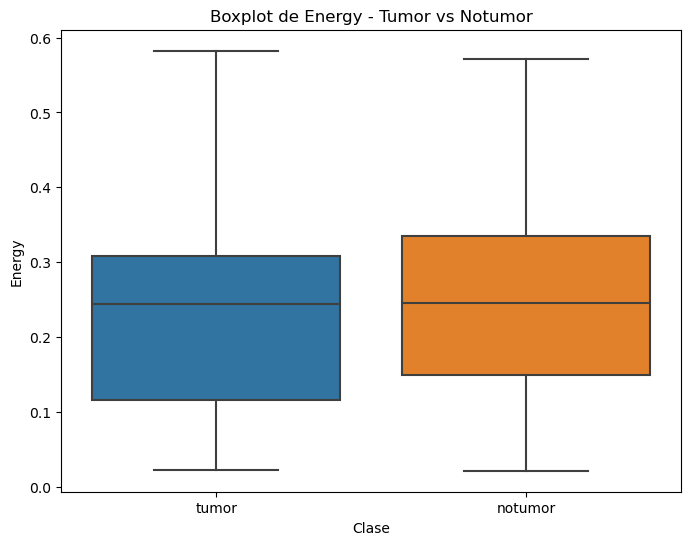

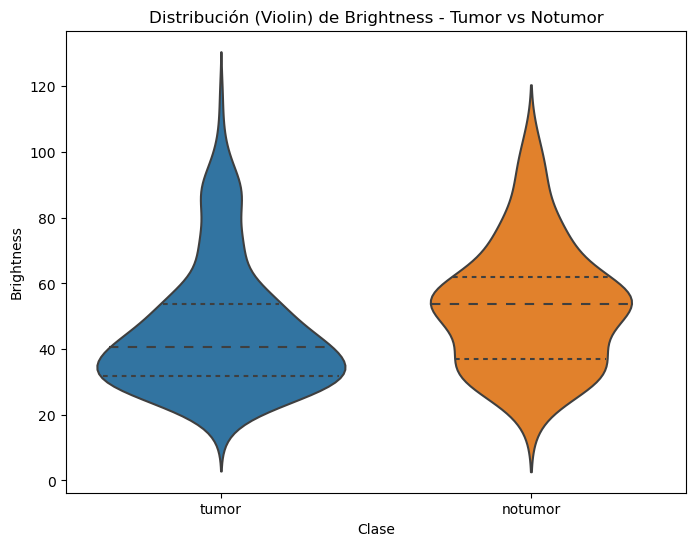

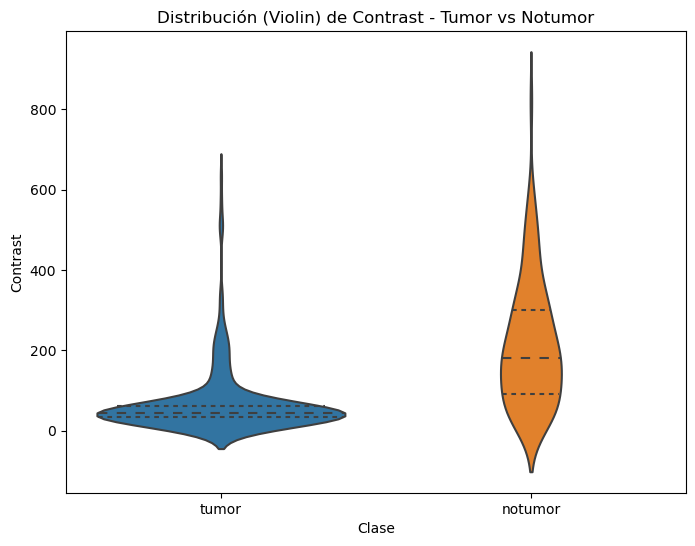

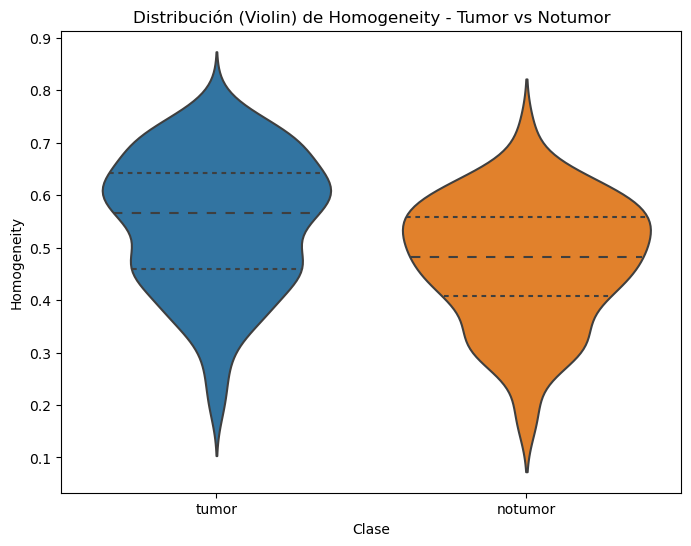

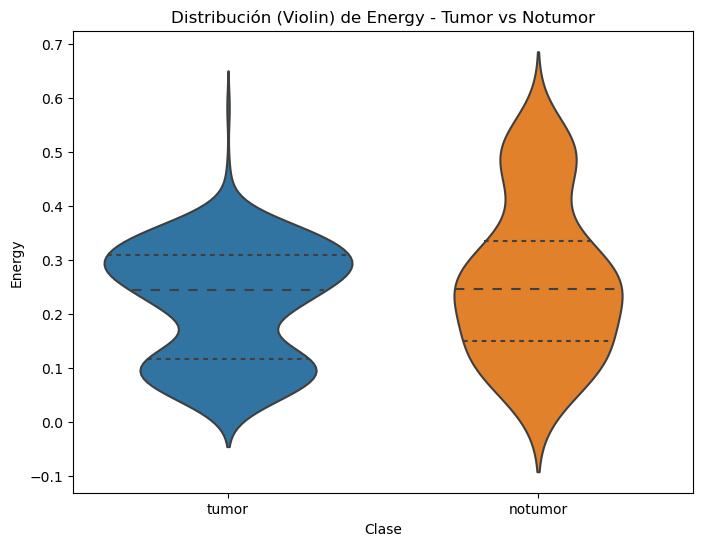

In [14]:
# ------------------------
# 1. Reagrupar clases: tumor vs notumor
# ------------------------
df_features_grouped = df_features.copy()
df_features_grouped["class_grouped"] = df_features_grouped["class"].apply(
    lambda x: "notumor" if x.lower() == "notumor" else "tumor"
)

print(df_features_grouped["class_grouped"].value_counts())

# ------------------------
# 2. Estadísticas descriptivas
# ------------------------
stats_grouped = df_features_grouped.groupby("class_grouped")[["brightness", "contrast", "homogeneity", "energy"]].agg(
    ["mean", "std", "min", "max"]
)

print("Estadísticas agrupadas:")
print(stats_grouped)

# ------------------------
# 3. Histogramas comparativos
# ------------------------
features_to_plot = ["brightness", "contrast", "homogeneity", "energy"]

for feat in features_to_plot:
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df_features_grouped, x=feat, hue="class_grouped",
                      element="step", stat="density", common_norm=False)
    ax.set_title(f"Distribución de {feat.capitalize()} - Tumor vs Notumor")
    ax.set_xlabel(feat.capitalize())
    ax.set_ylabel("Densidad")
    plt.legend(title="Clase")
    plt.show()

# ------------------------
# 4. Boxplots comparativos
# ------------------------
for feat in features_to_plot:
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data=df_features_grouped, x="class_grouped", y=feat)
    ax.set_title(f"Boxplot de {feat.capitalize()} - Tumor vs Notumor")
    plt.xlabel("Clase")
    plt.ylabel(feat.capitalize())
    plt.show()

# ------------------------
# 5. Violinplots comparativos
# ------------------------
for feat in features_to_plot:
    plt.figure(figsize=(8, 6))
    ax = sns.violinplot(data=df_features_grouped, x="class_grouped", y=feat, inner="quartile")
    ax.set_title(f"Distribución (Violin) de {feat.capitalize()} - Tumor vs Notumor")
    plt.xlabel("Clase")
    plt.ylabel(feat.capitalize())
    plt.show()



In [15]:
from scipy.stats import ttest_ind, f_oneway

# Definimos variables de interés
features_to_test = ["brightness", "saturation", "contrast", "homogeneity", "energy"]

# Filtrar datasets
tumor_data = df_features_grouped[df_features_grouped["class_grouped"] == "tumor"]
notumor_data = df_features_grouped[df_features_grouped["class_grouped"] == "notumor"]

# T-test entre Tumor y Notumor
print("==== T-TEST Tumor vs Notumor ====")
for feat in features_to_test:
    stat, p = ttest_ind(tumor_data[feat], notumor_data[feat], equal_var=False)
    print(f"{feat.capitalize()}: t={stat:.3f}, p={p:.4f} {'(Significativo ✔)' if p < 0.05 else '(No significativo ✘)'}")

# (Opcional) ANOVA si quisieras comparar TODAS las clases originales
print("\n==== ANOVA entre TODAS las clases originales ====")
for feat in features_to_test:
    groups = [df_features[df_features["class"] == cls][feat] for cls in df_features["class"].unique()]
    stat, p = f_oneway(*groups)
    print(f"{feat.capitalize()}: F={stat:.3f}, p={p:.4f} {'(Significativo ✔)' if p < 0.05 else '(No significativo ✘)'}")


==== T-TEST Tumor vs Notumor ====
Brightness: t=-3.291, p=0.0012 (Significativo ✔)
Saturation: t=nan, p=nan (No significativo ✘)
Contrast: t=-8.952, p=0.0000 (Significativo ✔)
Homogeneity: t=5.409, p=0.0000 (Significativo ✔)
Energy: t=-2.526, p=0.0127 (Significativo ✔)

==== ANOVA entre TODAS las clases originales ====
Brightness: F=35.066, p=0.0000 (Significativo ✔)
Saturation: F=nan, p=nan (No significativo ✘)
Contrast: F=57.007, p=0.0000 (Significativo ✔)
Homogeneity: F=44.338, p=0.0000 (Significativo ✔)
Energy: F=28.843, p=0.0000 (Significativo ✔)


c:\Users\moren\anaconda3\envs\globant_challenge\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
